In [1]:
import os
import functools as ftools
import itertools as itools
import pandas as pd
import polars as pl
import numpy as np

import sgml, dproc, sgnn, sgutil
import tensorflow as tf
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import dill

import seaborn as sns
import matplotlib.pyplot as plt

2024-11-25 02:12:26.277894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732500746.289461   15028 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732500746.292986   15028 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 02:12:26.305305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [3]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

with open(os.path.join('data', 'var_w.dill'), 'rb') as f:
    df_var = dill.load(f)
df_train = pd.read_feather(os.path.join('data', 'train_w.feather'))
sc = sgutil.SGCache('img', 'result')
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
target = 'Depression'

In [30]:
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: accuracy_score(df[target].sort_index(), prds.sort_index() > 0.5),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier)
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)
lr_adapter = sgml.SklearnAdapter(model=LogisticRegression)

def show_result_lgb(result):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.barplot(
        pd.concat([i['feature_importance'] for i in result['model_result']], axis=1).mean(axis=1)\
        .sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
        x = 'Importance', y = 'feature', ax=axes[0]
    )
    valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
    sns.lineplot(valid_result, ax=axes[1])
    if 'valid_1' in valid_result:
        axes[1].axvline(valid_result['valid_1'].idxmin())
    plt.tight_layout()
    plt.show()

In [5]:
df_var.sort_values('n_unique', ascending=False)

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
id,0.0,234499.0,0.0,234500.0,117250.0,True,True,False,False,Int32,Int32,None,org,None
Prof_Degree,None,None,0.0,140700.0,602.0,None,None,None,None,None,Categorical,Profession_R2과 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f85295491c0>
Name,None,None,0.0,234500.0,398.0,True,True,True,True,Categorical,Categorical,None,org,None
CGPA_FZ,0.0,10.0,0.0,140700.0,332.0,True,True,True,True,None,Float32,CGPA의 결측을 0으로 채운 변수입니다.,fillna,<function get_fillna_zero_proc.<locals>.<lambd...
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,None,org,None
Name_R,None,None,0.0,140700.0,218.0,None,None,None,None,None,Categorical,Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.,cat_proc,<function get_name_proc.<locals>.<lambda> at 0...
Degree,None,None,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,None,org,None
City,None,None,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,None,org,None
Profession,None,None,61262.0,173238.0,65.0,True,True,True,True,Categorical,Categorical,None,org,None
WS_Degree,None,None,0.0,140700.0,56.0,None,None,None,None,None,Categorical,Working Professional or Student와 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f85295496c0>


# LogisticRegression

In [31]:
cv_path = os.path.join('result', 'LR.cv')
if os.path.exists(cv_path):
    lr = sgml.CVModel.load('result', 'LR')
else:
    lr = sgml.CVModel('result', 'LR', skf, config, lr_adapter)

In [39]:
hparams = {
    'model_params': {'C': 1},
    'X_mm':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Name_R', 'Profession_R2', 'Age_2'],
    'ohe': {'drop': 'first', 'min_frequency': 50}
}

result = lr.cv(df_train, hparams)
np.mean(result['valid_scores'])

0.9392537313432836

# LGB1

In [6]:
cv_path = os.path.join('result', 'LGB1.cv')
if os.path.exists(cv_path):
    lgb1 = sgml.CVModel.load('result', 'LGB1')
else:
    lgb1 = sgml.CVModel('result', 'LGB1', skf, config, lgb_adapter)

In [844]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 15, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level', 'Work/Study Hours'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
}
# result = lgb1.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

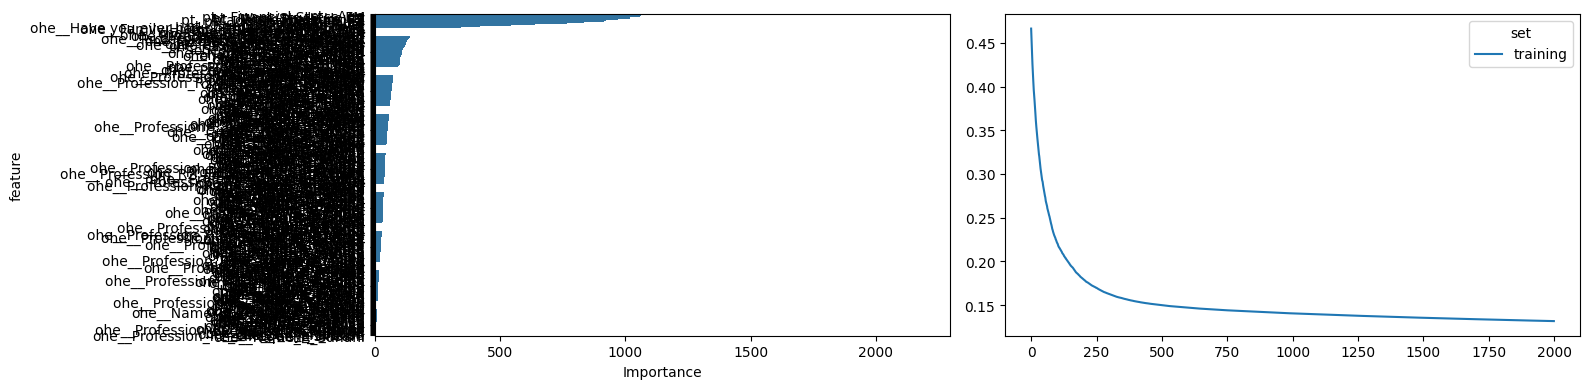

Accuracy, Valid.: 0.94043±0.00166


In [845]:
result = lgb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 15, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level, Work/Study Hours]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


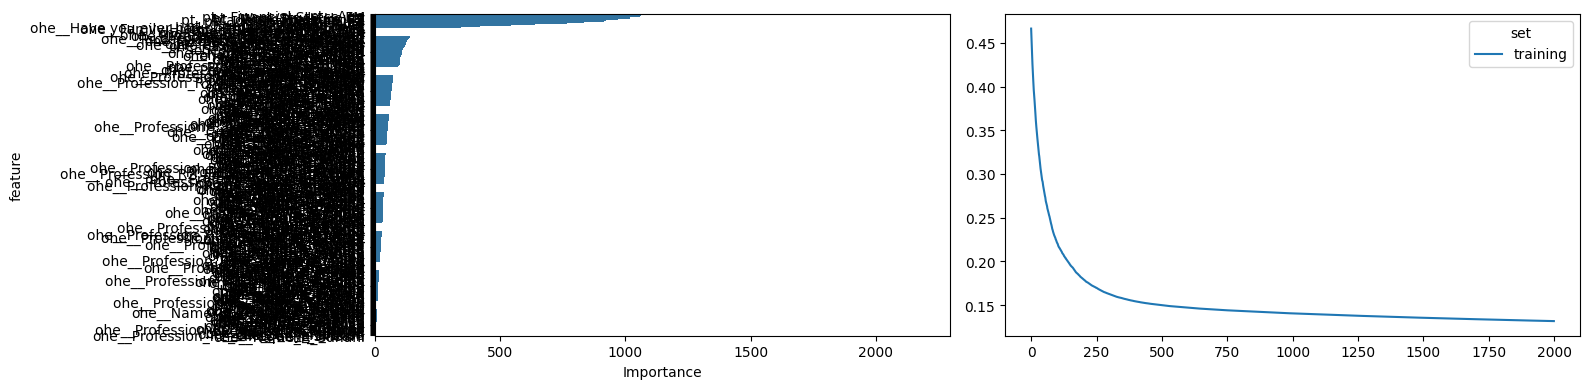

0.9404335465529495


In [846]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(lgb1.get_best_result())
print(lgb1.cv_best_['score'])

# XGB1

In [10]:
cv_path = os.path.join('result', 'XGB1.cv')
if os.path.exists(cv_path):
    xgb1 = sgml.CVModel.load('result', 'XGB1')
else:
    xgb1 = sgml.CVModel('result', 'XGB1', skf, config, xgb_adapter)

In [273]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'max_depth': 4, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    # 'validation_fraction': 0.1
}
# xgb1.adhoc(df_train, ss, hparams, device='cuda')

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

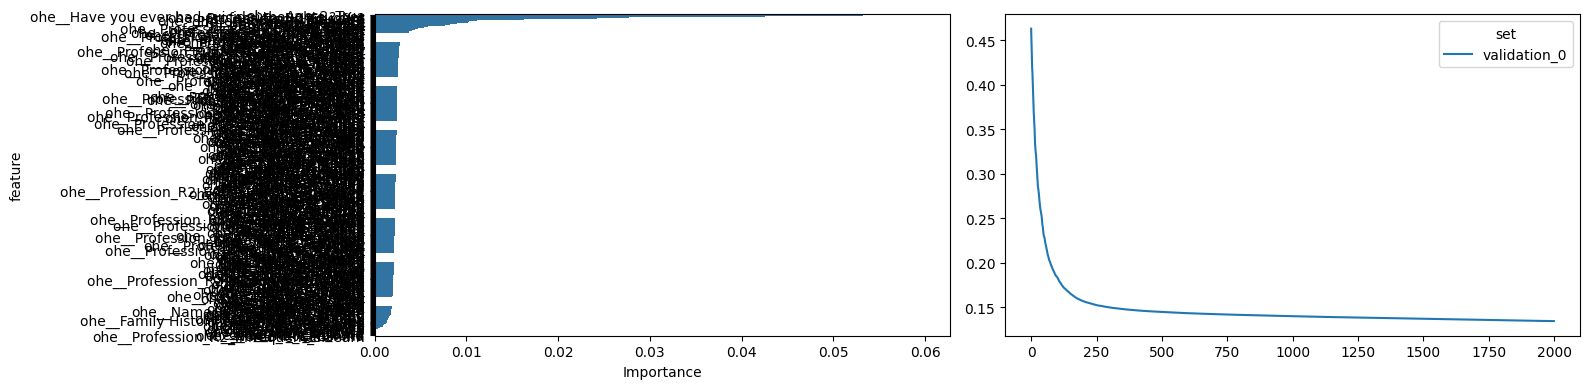

Accuracy, Valid.: 0.94025±0.00143


In [274]:
result = xgb1.cv(df_train, hparams, device='cuda')
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.04, 'max_depth': 4, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure, Financial Stress, Work Pressure, Study Satisfaction, Job Satisfaction, Work Hours, Study Hours, CGPA, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


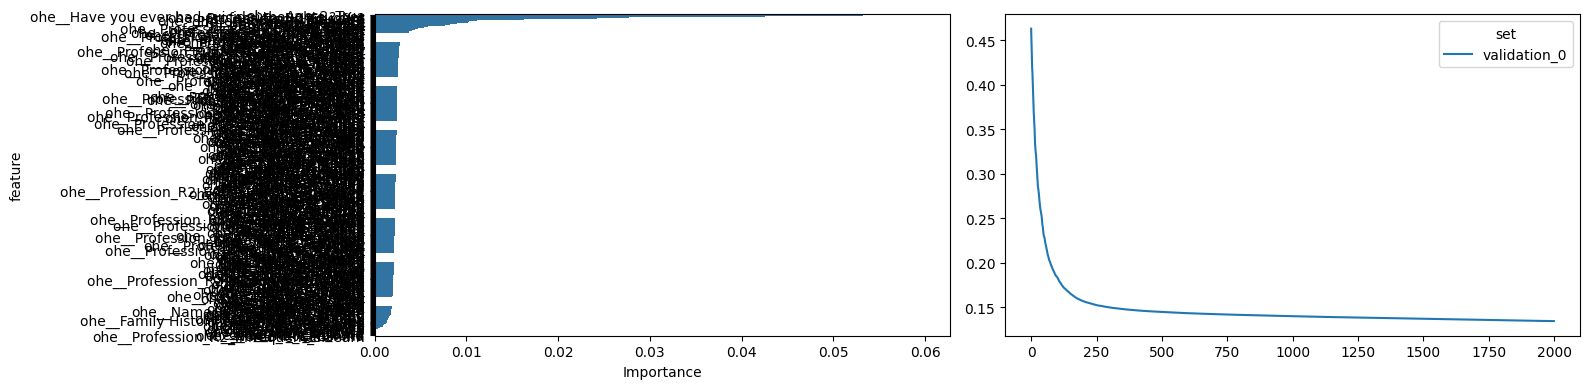

0.9402487562189055


In [275]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(xgb1.get_best_result())
print(xgb1.cv_best_['score'])

# XGB2

In [363]:
cv_path = os.path.join('result', 'XGB2.cv')
if os.path.exists(cv_path):
    xgb2 = sgml.CVModel.load('result', 'XGB2')
else:
    xgb2 = sgml.CVModel('result', 'XGB2', skf, config, xgb_adapter)

In [371]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.06, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    # 'validation_fraction': 0.1
}
# xgb2.adhoc(df_train, ss, hparams, device='cuda')

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

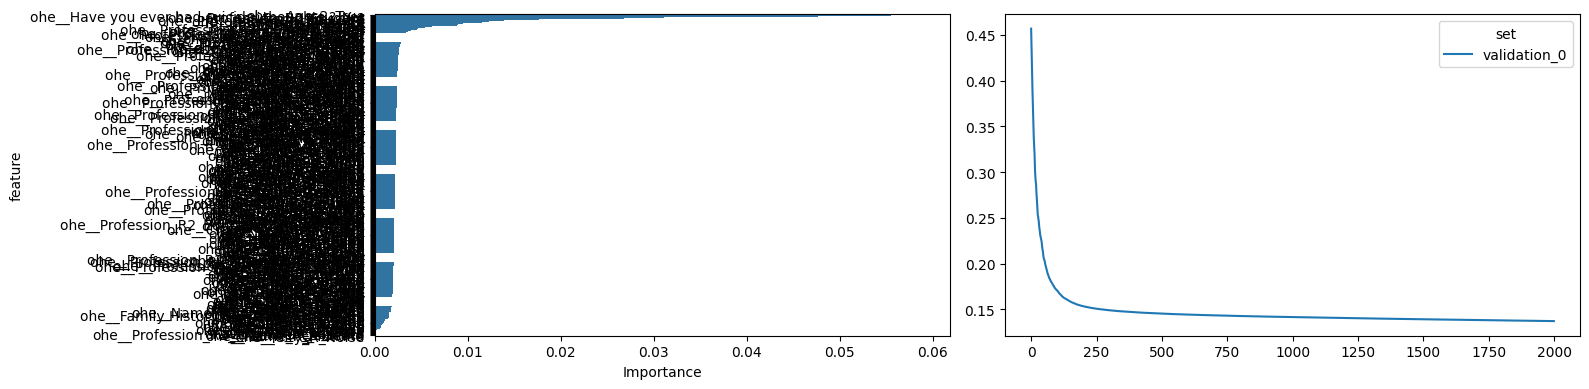

Accuracy, Valid.: 0.94024±0.00120


In [372]:
result = xgb2.cv(df_train, hparams, device='cuda')
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.04, 'max_depth': 4, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure, Financial Stress, Work Pressure, Study Satisfaction, Job Satisfaction, Work Hours, Study Hours, CGPA, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


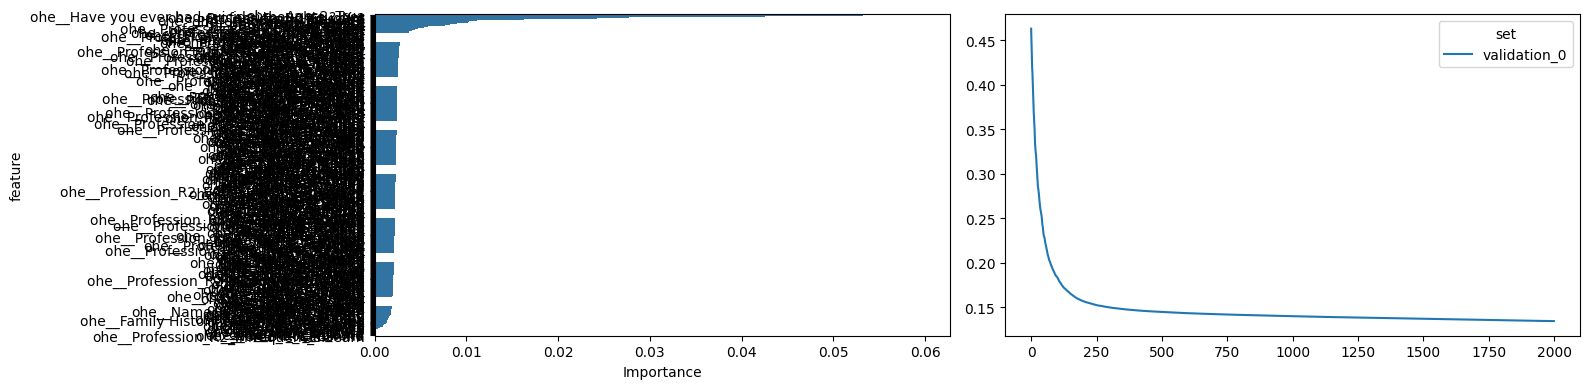

0.9402487562189055


In [373]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(xgb1.get_best_result())
print(xgb1.cv_best_['score'])

# CB

In [14]:
cv_path = os.path.join('result', 'CB1.cv')
if os.path.exists(cv_path):
    cb1 = sgml.CVModel.load('result', 'CB1')
else:
    cb1 = sgml.CVModel('result', 'CB1', skf, config, cb_adapter)

In [22]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.05, 'max_depth': 5, 'rsm': 0.5},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
}
# cb1.adhoc(df_train, ss, hparams)

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

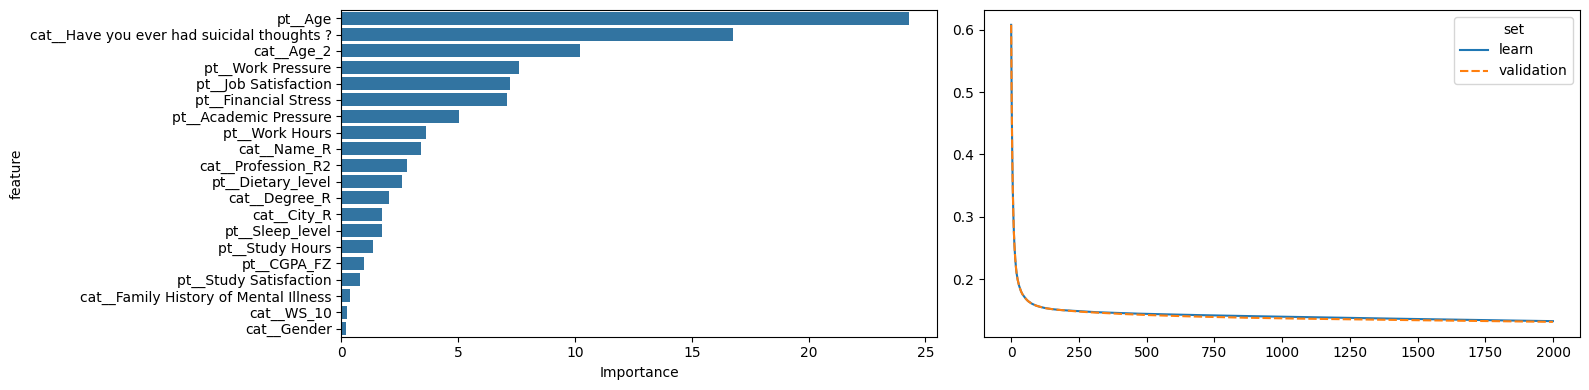

Accuracy, Valid.: 0.94044±0.00188


In [23]:
result = cb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.05, 'random_state': 123, 'rsm': 0.5}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


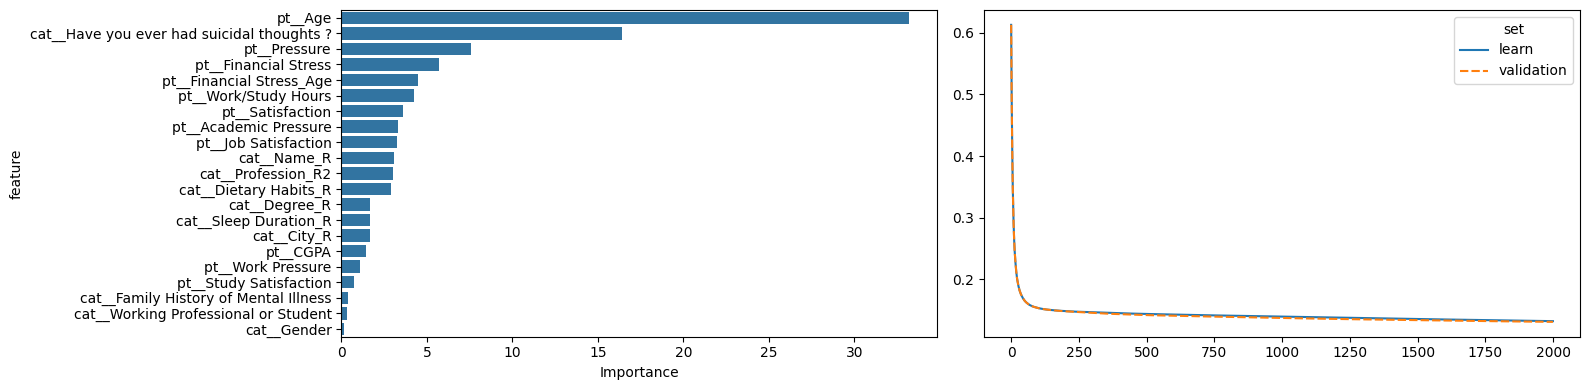

0.9404619758351102


In [123]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(cb1.get_best_result())
print(cb1.cv_best_['score'])

# NN

In [126]:
import sgnn
nn_adapter = sgnn.NNAdapter(model=sgnn.NNClassifier)

In [127]:
cv_path = os.path.join('result', 'NN1.cv')
if os.path.exists(cv_path):
    nn1 = sgml.CVModel.load('result', 'NN1')
else:
    nn1 = sgml.CVModel('result', 'NN1', skf, config, nn_adapter)

In [165]:
def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size

X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R']
X_nn_emb = [
    ('Name_R', 3), ('City_R', 2), ('Profession_R2', 2), ('Degree_R', 2)
]

nn_params = {
    'embedding':[(1, c, es, 0, 0) for _, c, es in [nn_cat_param(df_train, v, n) for v, n in X_nn_emb]], 
    'config':  [
        {'unit': 4, 'activation': 'relu', 'batch_norm': False},
#        {'unit': 4, 'activation': 'relu', 'batch_norm': False},
    ]
}

hparams = {
    'model_params': {
        'model_params': nn_params,
        'epochs': 30,
        'optimizer': ('Adam', {'learning_rate': 0.002}),
        'batch_size': 2048, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_cat': [i for i, _ in X_nn_emb],
    'X_std':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Age_2'],
    'ohe': {'drop': 'first', 'min_frequency': 50, 'sparse_output': False},
    #'validation_fraction': 0.1
}

# nn1.adhoc(df_train, ss, hparams)

In [170]:
"""
class DepressionModel(tf.keras.Model):
    def __init__(self, emb_cols, cont_cols, f_size, left_layers, right_layers, top_layers):
        super().__init__()
        if emb_cols != None:
            self.emb_layers = {
                v.replace(' ', '_').replace('?', '_'): tf.keras.layers.Embedding(c, s, name=v.replace(' ', '_').replace('?', '_')) for v, c, s in emb_cols
            }
            self.emb_cc = tf.keras.layers.Concatenate(axis=-1)
            if left_layers != None:
                self.left_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in left_layers
                ])
                self.right_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in right_layers
                ])
                self.mul = tf.keras.layers.Multiply()
                self.left_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.left_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
                self.right_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.right_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
            else:
                self.left_model = None
        else:
            self.emb_layers = None
        self.top_cc = tf.keras.layers.Concatenate(axis=-1)
        self.top_model = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in top_layers
        ])
        self.f_size = f_size
        self.cont_cols = cont_cols
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def __call__(self, X):
        if self.emb_layers != None:
            X_emb = self.emb_cc([tf.squeeze(v(X[k]), axis=-2) for k, v in self.emb_layers.items()])
            if self.left_model !=None:
                X_left = self.left_model(X_emb)
                X_right = self.right_model(X_emb)
                X_left_1 = self.left_slice_layer_1(X_left)
                X_left_2 = self.left_slice_layer_2(X_left)
                
                X_right_1 = self.right_slice_layer_1(X_right)
                X_right_2 = self.right_slice_layer_2(X_right)
                X_mul = self.mul([X_left_1, X_right_1])
                cc_list = [X_left_2, X_right_2, X_mul]
            else:
                cc_list = [X_emb]
        else:
            cc_list = list()
        if self.cont_cols != None:
            cc_list.append(X[self.cont_cols])
        if len(cc_list) == 1:
            return self.sigmoid(
                self.top_model(cc_list[0])
            )
        else:
            return self.sigmoid(
                self.top_model(self.top_cc(cc_list))
            )

def to_tf_dataset(X, Y=None, sample_weights=None, cont=[], cat=[]):
    d = {}
    c = 0
    for i in cat:
        d[i.replace(' ', '_').replace('?', '_')] = np.expand_dims(X[:, c].astype('int'), axis=-1)
        c += 1
        
    if len(cont) > 0:
        d['Continous'] =  X[:, c:]
    if Y is None:
        return tf.data.Dataset.from_tensor_slices(d)
    else:
        if type(Y) == pd.Series:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y.values))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y.values, sample_weights.values))
        else:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y, sample_weights))

def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size


X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R', 'Sleep Duration_R', 'Dietary Habits_R', 
         'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness']
X_num = ['CGPA_FZ', 'Work Hours', 'Study Hours', 'Work Pressure_FZ', 'Academic Pressure_FZ', 
         'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Age', 'Financial Stress_FM', 'Sleep_level', 'Dietary_level']
X_nn_emb = [
    ('Name_R', 2), ('City_R', 2), ('Profession_R2', 2), ('Degree_R', 2), ('Sleep Duration_R', 1), ('Dietary Habits_R', 1), ('Working Professional or Student', 1), 
    ('Have you ever had suicidal thoughts ?', 1), ('Gender', 1), ('Family History of Mental Illness', 1)
]

nn_adapter = sgnn.NNAdapter(
    model=sgnn.NNClassifier,
    to_tf_dataset = ftools.partial(
        to_tf_dataset, 
        cont=X_num,
        cat=X_cat
    )
)
"""
' '

' '

In [169]:
"""nn_params = {
    'emb_cols': [
        nn_cat_param(df_train, v, n) for v, n in X_nn_emb
    ], 
    'cont_cols':  'Continous',
    'f_size':  16, 
    'left_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'right_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'top_layers': [
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 16, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 1, 'kernel_initializer': 'glorot_uniform'}
    ]
}

hparams = {
    'model_params': {
        'model': DepressionModel, 
        'model_params': nn_params,
        'epochs': 30,
        'optimizer': ('Adam', {'learning_rate': 0.0005}),
        'batch_size': 512, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_std': X_num,
    'X_cat': X_cat,
    'ohe': {'drop': 'first'}
}
nn1.adhoc(df_train, ss, hparams)
"""
' '

' '

In [166]:
result = nn1.cv(df_train, hparams)
print_metrics('Valid.', result['valid_scores'])

Accuracy, Valid.: 0.93942±0.00140


In [167]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(nn1.cv_best_['hparams']).rename('value').to_frame())
print(nn1.cv_best_['score'])

,value
model_params,"{'model_params': {'embedding': [(1, 218, 3, 0, 0), (1, 31, 2, 0, 0), (1, 38, 2, 0, 0), (1, 28, 2, 0, 0)], 'config': [{'unit': 4, 'activation': 'relu', 'batch_norm': False}]}, 'epochs': 30, 'optimizer': ('Adam', {'learning_rate': 0.002}), 'batch_size': 2048, 'shuffle_size': 102400, 'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None}"
X_cat,"[Name_R, City_R, Profession_R2, Degree_R]"
X_std,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level]"
X_ohe,"[Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Age_2]"
ohe,"{'drop': 'first', 'min_frequency': 50, 'sparse_output': False}"


0.9394243070362472


# LGB + LDA

In [780]:
cv_path = os.path.join('result', 'LGB_LDA.cv')
if os.path.exists(cv_path):
    lgb_lda = sgml.CVModel.load('result', 'LGB_LDA')
else:
    lgb_lda = sgml.CVModel('result', 'LGB_LDA', skf, config, lgb_adapter)

In [781]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.04,
        'random_state' : 123,
        'colsample_bytree' : 0.25,
        'subsample': 0.25
    }, 
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'lda': {
        'X_mm':  [
            'Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ'
        ],
    }
}
# result = lgb_lda.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

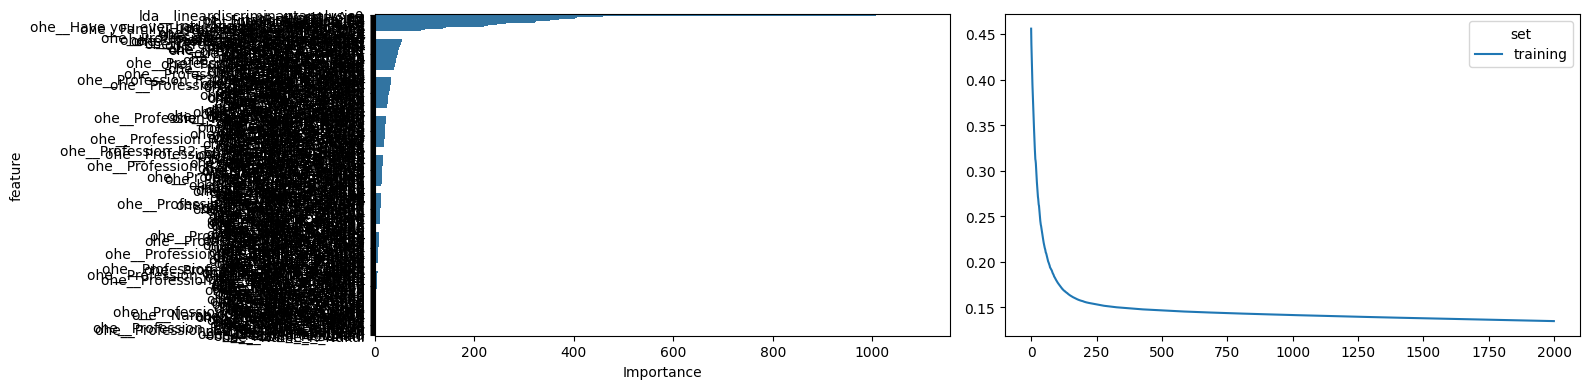

Accuracy, Valid.: 0.94007±0.00149


In [782]:
result = lgb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [783]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(lgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 7, 'learning_rate': 0.04, 'random_state': 123, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"
lda,"{'X_mm': ['Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ']}"


0.9400710732054016


# LGB2

num_leaves를 15 → 7로 낮추어 모델을 구성합니다.

In [321]:
cv_path = os.path.join('result', 'LGB2.cv')
if os.path.exists(cv_path):
    lgb2 = sgml.CVModel.load('result', 'LGB2')
else:
    lgb2 = sgml.CVModel('result', 'LGB2', skf, config, lgb_adapter)

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

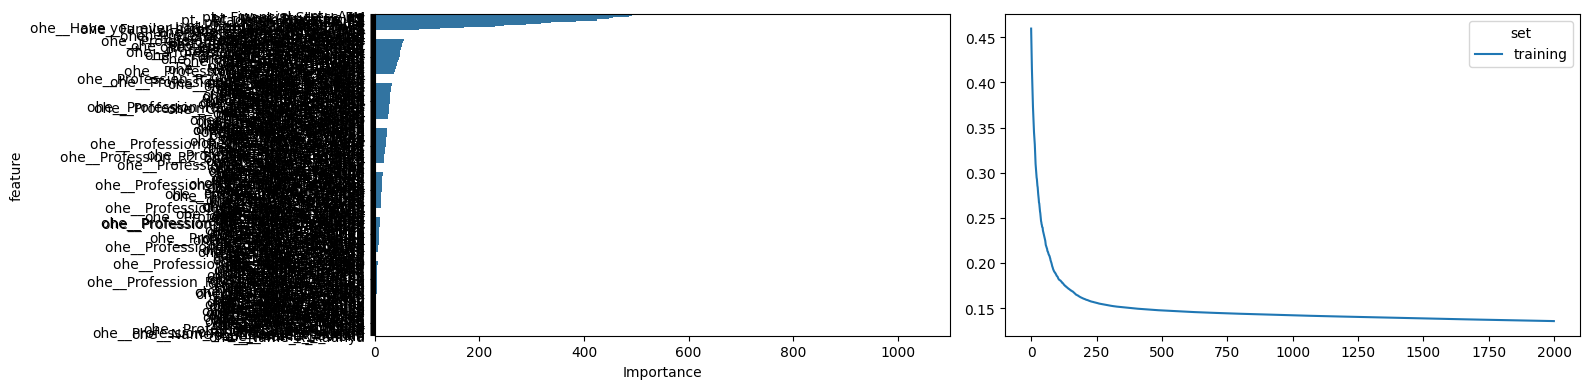

[0.9400497512437811]


In [332]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'num_leaves': 7, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level', 'Work/Study Hours'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
}
#result = lgb2.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['valid_scores'])

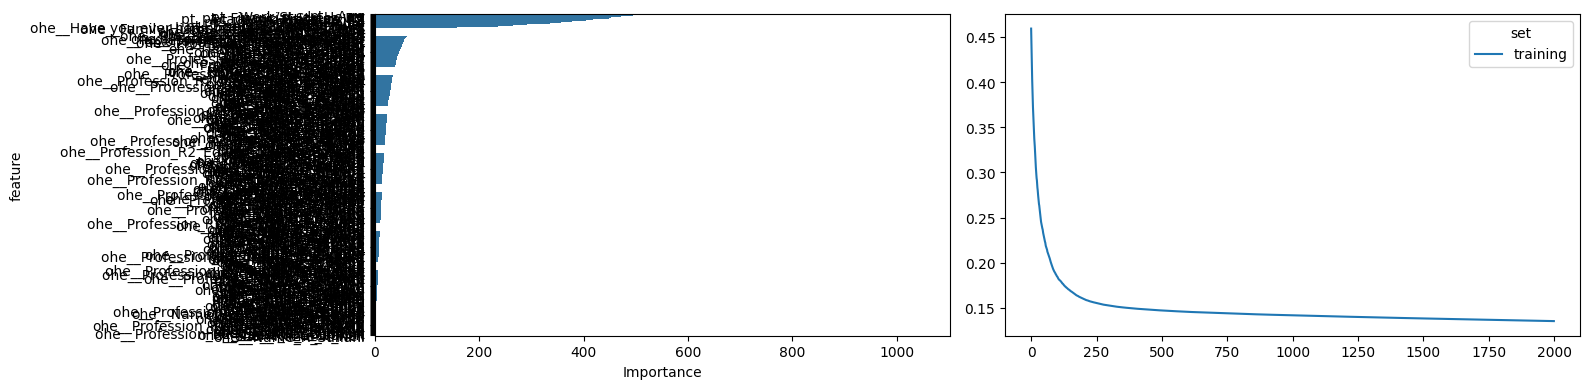

Accuracy, Valid.: 0.94033±0.00192


In [336]:
result = lgb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [338]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb2.cv_best_['hparams']).rename('value').to_frame())
print(lgb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.04, 'num_leaves': 7, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level, Work/Study Hours]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


0.9403340440653875


# XGB + LDA

In [212]:
cv_path = os.path.join('result', 'XGB_LDA.cv')
if os.path.exists(cv_path):
    xgb_lda = sgml.CVModel.load('result', 'XGB_LDA')
else:
    xgb_lda = sgml.CVModel('result', 'XGB_LDA', skf, config, xgb_adapter)

In [765]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.06, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'lda': {
        'X_mm':  [
            'Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ',
            'Dietary_level', 'Sleep_level'
        ],
    },
}
# result = xgb_lda.adhoc(df_train, ss, hparams, device='cuda')
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

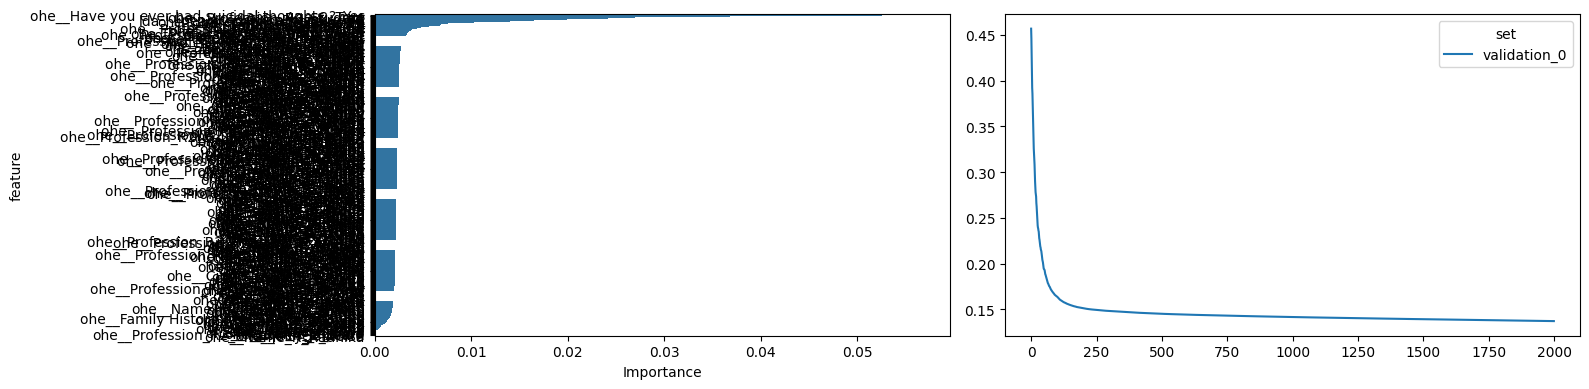

Accuracy, Valid.: 0.94027±0.00138


In [766]:
result = xgb_lda.cv(df_train, hparams, device='cuda')
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [767]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(xgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.06, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"
lda,"{'X_mm': ['Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Dietary_level', 'Sleep_level']}"


0.940270078180526


# CB2

In [294]:
cv_path = os.path.join('result', 'CB2.cv')
if os.path.exists(cv_path):
    cb2 = sgml.CVModel.load('result', 'CB2')
else:
    cb2 = sgml.CVModel('result', 'CB2', skf, config, cb_adapter)

In [296]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.07, 'max_depth': 4, 'rsm': 0.5},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    #'validation_fraction': 0.1
}
#result = cb2.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['train_scores'], result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

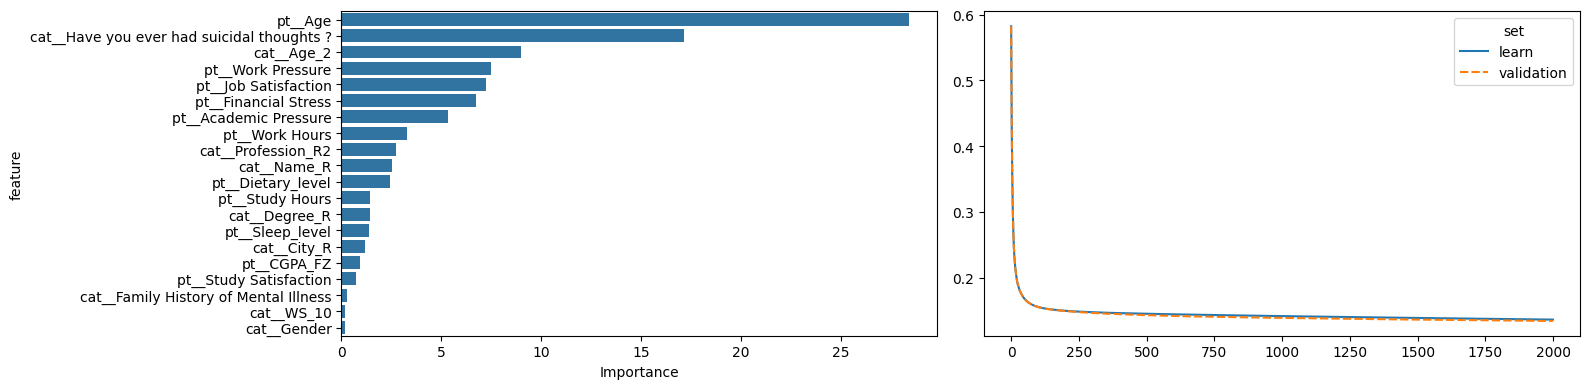

Accuracy, Valid.: 0.94043±0.00197


In [297]:
result = cb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [298]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb2.cv_best_['hparams']).rename('value').to_frame())
print(cb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.07, 'random_state': 123, 'rsm': 0.75}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


0.9404406538734896


# CB3

In [308]:
cv_path = os.path.join('result', 'CB3.cv')
if os.path.exists(cv_path):
    cb3 = sgml.CVModel.load('result', 'CB3')
else:
    cb3 = sgml.CVModel('result', 'CB3', skf, config, cb_adapter)

In [312]:
hparams = {
    'model_params': {'n_estimators': 1800, 'learning_rate': 0.05, 'max_depth': 6, 'rsm': 0.5},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    #'validation_fraction': 0.1
}
# cb3.adhoc(df_train, ss, hparams)

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/1800 [00:00<?, ?it/s]

Round:   0%|          | 0/1800 [00:00<?, ?it/s]

Round:   0%|          | 0/1800 [00:00<?, ?it/s]

Round:   0%|          | 0/1800 [00:00<?, ?it/s]

Round:   0%|          | 0/1800 [00:00<?, ?it/s]

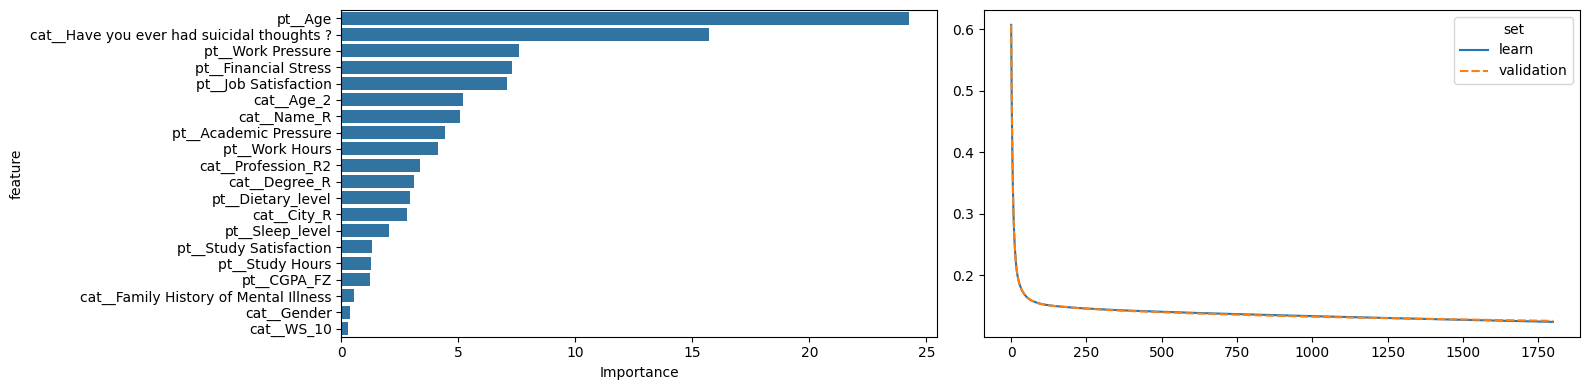

Accuracy, Valid.: 0.94021±0.00171


In [313]:
result = cb3.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

# CB + LDA

In [419]:
cv_path = os.path.join('result', 'CB_LDA.cv')
if os.path.exists(cv_path):
    cb_lda = sgml.CVModel.load('result', 'CB_LDA')
else:
    cb_lda = sgml.CVModel('result', 'CB_LDA', skf, config, cb_adapter)

In [690]:
hparams = {
    'model_params': {'n_estimators': 2500, 'learning_rate': 0.07, 'max_depth': 3},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'lda': {
        'X_mm':  [
            'Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ',
        ],
        'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first', 'sparse_output': False}
    },
    #'validation_fraction': 0.1
}
# result = cb_lda.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2500 [00:00<?, ?it/s]

Round:   0%|          | 0/2500 [00:00<?, ?it/s]

Round:   0%|          | 0/2500 [00:00<?, ?it/s]

Round:   0%|          | 0/2500 [00:00<?, ?it/s]

Round:   0%|          | 0/2500 [00:00<?, ?it/s]

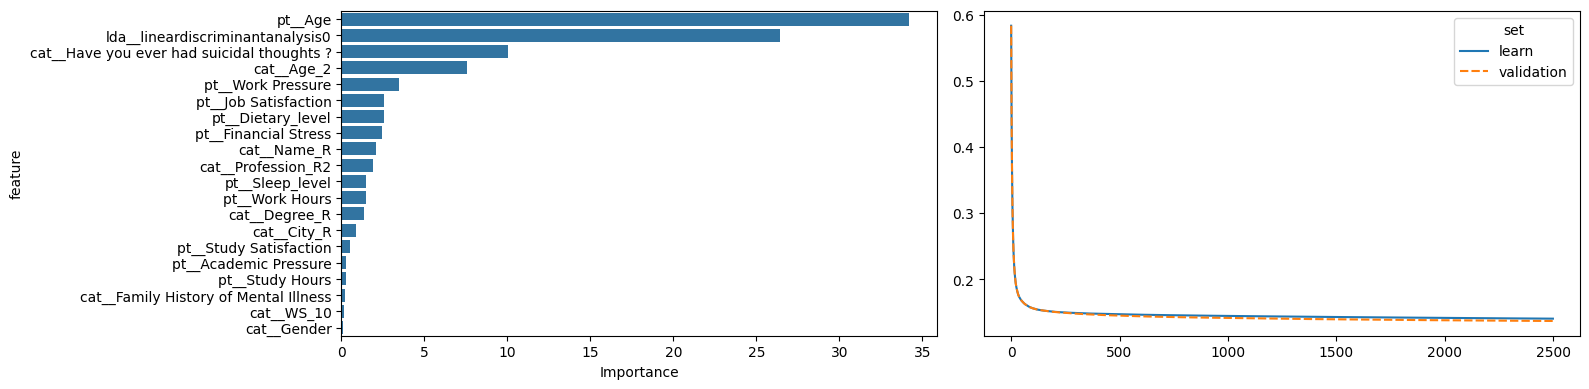

Accuracy, Valid.: 0.94055±0.00149


In [691]:
result = cb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [692]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb_lda.cv_best_['hparams']).rename('value').to_frame())
print(cb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2500, 'learning_rate': 0.07, 'max_depth': 3}"
X_num,"[Age, Academic Pressure, Financial Stress, Work Pressure, Study Satisfaction, Job Satisfaction, Work Hours, Study Hours, Dietary_level, Sleep_level]"
X_cat,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
lda,"{'X_mm': ['Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first', 'sparse_output': False}}"


0.940547263681592


# Stacking

In [784]:
models = [lr, lgb1, lgb2, xgb1, xgb2, cb1, cb2, cb3, nn1, xgb_lda, lgb_lda, cb_lda]
pd.Series([i.cv_best_['score'] for i in models], index=[i.name for i in models]).sort_values(ascending=False).to_frame().T

,CB_LDA,CB1,CB2,LGB1,LGB2,XGB_LDA,XGB1,XGB2,CB3,LGB_LDA,NN1,LR
0,0.940547,0.940462,0.940441,0.940434,0.940334,0.94027,0.940249,0.940242,0.940206,0.940071,0.939424,0.939254


In [785]:
df_stk = sgml.stack_cv(models, df_train[target]).sort_index()
df_stk.corr()

,LR,LGB1,LGB2,XGB1,XGB2,CB1,CB2,CB3,NN1,XGB_LDA,LGB_LDA,CB_LDA,Depression
LR,1.000000,0.994376,0.994685,0.994234,0.994266,0.991516,0.991641,0.990975,0.998134,0.994231,0.994810,0.992493,0.836811
LGB1,0.994376,1.000000,0.999261,0.997241,0.996914,0.995709,0.995594,0.995257,0.993613,0.996561,0.998583,0.995872,0.839538
LGB2,0.994685,0.999261,1.000000,0.996893,0.996692,0.995454,0.995416,0.994893,0.993800,0.996338,0.998815,0.995700,0.839495
XGB1,0.994234,0.997241,0.996893,1.000000,0.998908,0.994490,0.994490,0.994190,0.993557,0.997712,0.996450,0.994550,0.839248
XGB2,0.994266,0.996914,0.996692,0.998908,1.000000,0.994170,0.994187,0.993792,0.993522,0.997831,0.996226,0.994286,0.839053
CB1,0.991516,0.995709,0.995454,0.994490,0.994170,1.000000,0.998901,0.997739,0.990567,0.993640,0.995142,0.997460,0.839125
CB2,0.991641,0.995594,0.995416,0.994490,0.994187,0.998901,1.000000,0.997465,0.990617,0.993661,0.995111,0.997434,0.839168
CB3,0.990975,0.995257,0.994893,0.994190,0.993792,0.997739,0.997465,1.000000,0.990206,0.993202,0.994597,0.997417,0.839396
NN1,0.998134,0.993613,0.993800,0.993557,0.993522,0.990567,0.990617,0.990206,1.000000,0.993567,0.993886,0.991537,0.836428
XGB_LDA,0.994231,0.996561,0.996338,0.997712,0.997831,0.993640,0.993661,0.993202,0.993567,1.000000,0.996116,0.994209,0.838932


In [786]:
(
    accuracy_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB3', 'XGB1', 'XGB2', 'LGB1', 'LGB2', 'LGB_LDA', 'CB_LDA', 'XGB_LDA']].mean(axis=1) >= 0.5
    ),
    accuracy_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB3', 'XGB1', 'LGB1', 'LGB2', 'LGB_LDA']].mean(axis=1) >= 0.5
    ),
    roc_auc_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB3', 'XGB1', 'XGB2', 'LGB1', 'LGB2', 'LGB_LDA', 'CB_LDA', 'XGB_LDA']].mean(axis=1)
    ), 
    roc_auc_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB3', 'XGB1', 'LGB1', 'LGB2', 'LGB_LDA']].mean(axis=1)
    )
)

(0.9408315565031983, 0.940817341862118, 0.9763399042073577, 0.9763050625809574)

In [787]:
from sklearn.linear_model import LogisticRegression
lr_adapter = sgml.SklearnAdapter(LogisticRegression)

cv_path = os.path.join('result', 'stk_lr.cv')
if os.path.exists(cv_path):
    stk = sgml.CVModel.load('result', 'stk_lr')
else:
    skf2 = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)
    stk = sgml.CVModel('result', 'stk_lr', skf2, config, lr_adapter)

In [788]:
hparams={
    'model_params' : {'C': 10},
    'X_num': ['CB1', 'CB2', 'CB3', 'XGB1', 'XGB2', 'LGB1', 'LGB2', 'LGB_LDA', 'CB_LDA', 'XGB_LDA']
}
result = stk.cv(df_stk, hparams, result_proc=sgml.m_learning_result, rerun=1)
print_metrics('Valid. score', result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy, Valid. score: 0.94043±0.00144


In [789]:
pd.concat(
    [pd.Series(i['model'].coef_[0], index=i['variables']) for i in result['model_result']], axis=1
)

,0,1,2,3,4
CB1,0.741242,0.742899,0.743640,0.739315,0.738405
CB3,0.759758,0.760252,0.762558,0.757241,0.756779
LGB_LDA,0.733990,0.730968,0.734054,0.731454,0.732348
LGB2,0.735358,0.734593,0.731870,0.734180,0.731631
LGB1,0.730780,0.732483,0.728798,0.734800,0.730845
CB_LDA,0.755502,0.763307,0.755498,0.752903,0.758220
CB2,0.740913,0.743039,0.745115,0.742487,0.742377
XGB1,0.734279,0.734691,0.731312,0.739398,0.733310
XGB2,0.732720,0.731553,0.729599,0.739146,0.737218
XGB_LDA,0.734044,0.737433,0.728981,0.737752,0.738714


In [960]:
df_confuse = df_train.loc[
    stk.cv_best_['prd'].sort_index().between(0.3, 0.7)
].assign(
    prob = lambda x: stk.cv_best_['prd']
)

In [961]:
len(df_confuse) / len(df_train), roc_auc_score(df_confuse[target], df_confuse['prob'])

(0.03547974413646055, 0.5717164358124617)

In [962]:
df_confuse[target].value_counts()

Depression
1    2695
0    2297
Name: count, dtype: int64

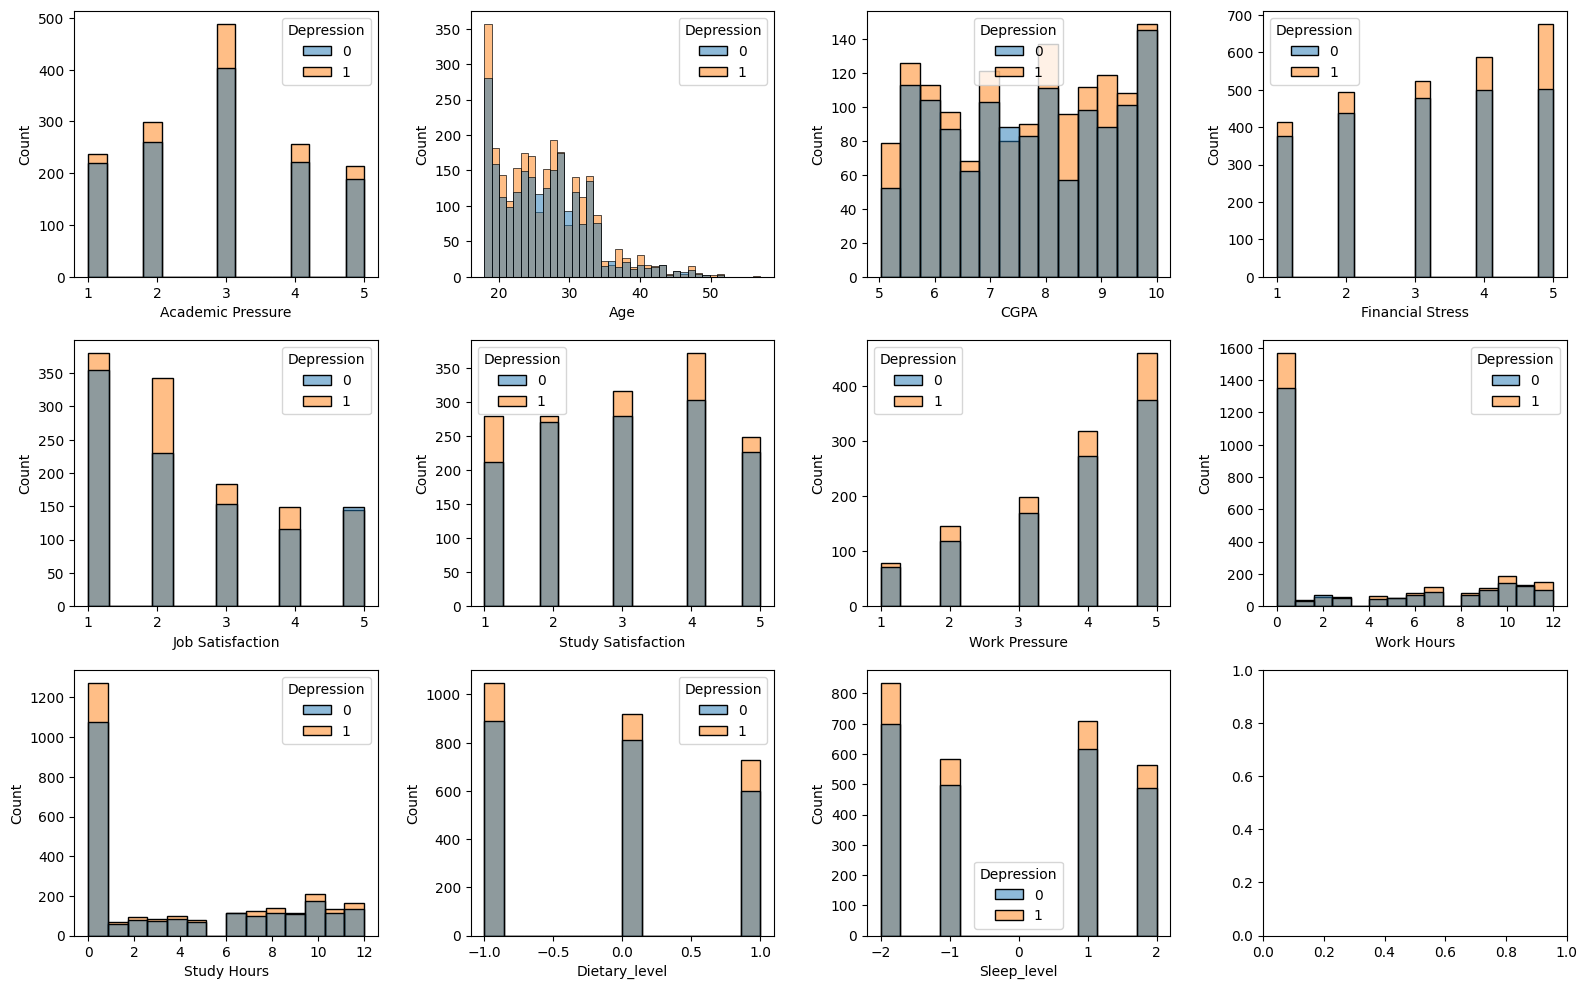

In [963]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Job Satisfaction', 'Study Satisfaction',  'Work Pressure', 
          'Work Hours', 'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confuse, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [1002]:
hparams = {
    'model_params': {'n_estimators': 100, 'num_leaves': 3},
    'X_num':  [
       'Financial Stress_FM'
    ],
    'X_ohe': ['Family History of Mental Illness', 'Gender'],
    'ohe': {'min_frequency': 10, 'drop': 'if_binary', 'handle_unknown': 'ignore'},
}
result = lgb1.adhoc(df_confuse, StratifiedKFold(5), hparams)

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

In [1003]:
result['model_result'][0]['feature_importance'][-20:], result['train_scores'], result['valid_scores'], roc_auc_score(df_confuse[target].sort_index(), result['valid_prd'].sort_index())

(ohe__Gender_Male                             32
 ohe__Family History of Mental Illness_Yes    71
 pt__Financial Stress_FM                      97
 dtype: int32,
 [0.5432006010518408,
  0.5504633107938893,
  0.5478217325988983,
  0.5480721081622434,
  0.5408112168252378],
 [0.5385385385385385,
  0.5315315315315315,
  0.5490981963927856,
  0.5390781563126252,
  0.5410821643286573],
 0.5228679337330373)

In [1004]:
df_train.pivot_table(index=['Family History of Mental Illness', 'Gender'], columns=target, aggfunc='size', observed=False).assign(
    ratio = lambda x: x[1] / x.sum(axis=1)
)

Depression                                   0     1     ratio
Family History of Mental Illness Gender                       
No                               Female  25939  5320  0.170191
                                 Male    32409  7090  0.179498
Yes                              Female  26026  5951  0.186103
                                 Male    30759  7206  0.189806

In [1006]:
df_confuse.pivot_table(index=['Family History of Mental Illness', 'Gender'], columns=target, aggfunc='size', observed=False).assign(
    ratio = lambda x: x[1] / x.sum(axis=1)
)

Depression                                 0    1     ratio
Family History of Mental Illness Gender                    
No                               Female  557  587  0.513112
                                 Male    634  791  0.555088
Yes                              Female  487  631  0.564401
                                 Male    619  686  0.525670

In [ ]:
for i in models:
    i.train(df_train)

In [ ]:
df_test = pl.read_parquet(files['test_parquet'])
df_test = df_test.to_pandas().set_index('id')

In [ ]:
df_test, nq = dproc.apply_pd_procs(df_test, df_var.loc[df_var['processor'].notna(), 'processor'])
df_test

In [ ]:
df_stk_test = sc.cache_result(
    'stk_test',
    lambda : sgml.stack_prd(models, df_test, config)
)
df_stk_test.head()

In [ ]:
stk.train(df_stk)

In [ ]:
stk.get_predictor()(df_stk_test)